# <font color="green">Desafío- Prediciendo las ventas de una tienda</font>

## <font color="green">Descripción</font>

<p> En esta tarea, se te presenta el desafiante escenario de predecir las ventas mensuales de
 una tienda utilizando técnicas de análisis de series de tiempo. El objetivo principal es aplicar
 un enfoque riguroso de análisis y modelado de series de tiempo para realizar predicciones
 precisas de las ventas futuras.</p>
 <p>La tienda ha recopilado datos históricos de ventas mensuales durante varios años, en el
 archivo <b>Sales_Data.xlsx.</b> Tu tarea es desarrollar un modelo que sea capaz de predecir las
 ventas mensuales futuras basándose en estos datos.
 </p>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

In [39]:
sales = pd.read_excel('Sales_Data.xlsx')
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  48 non-null     datetime64[ns]
 1   Sales       48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [40]:
sales.head()

,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [41]:
time_series = sales.set_index('Order Date')

In [42]:
time_series.index = pd.to_datetime(time_series.index)
time_series = time_series.asfreq('MS')

In [55]:
time_series.tail()

,Sales
Order Date,
2018-08-01,62837.8480
2018-09-01,86152.8880
2018-10-01,77448.1312
2018-11-01,117938.1550
2018-12-01,83030.3888


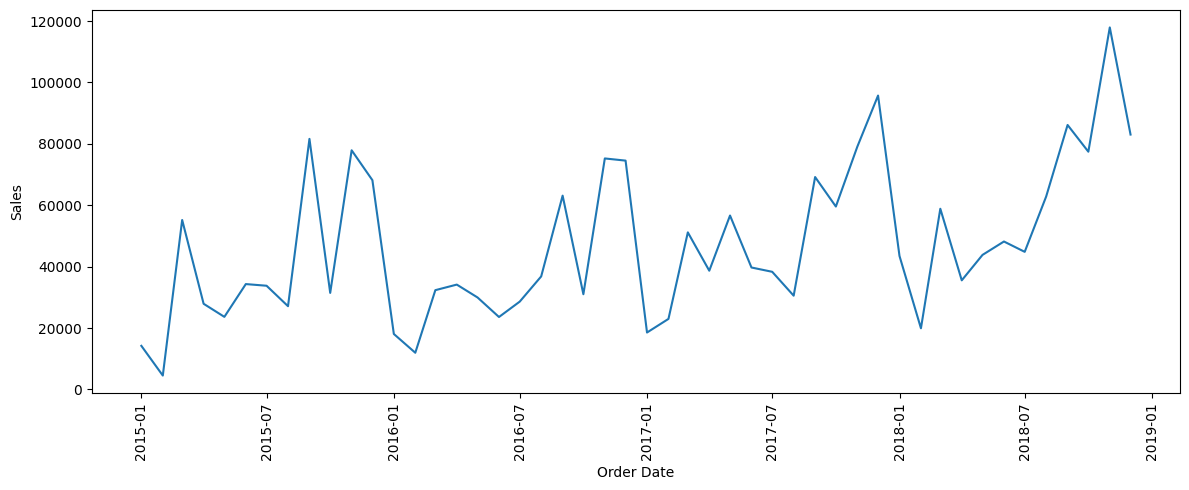

In [44]:
plt.figure(figsize=(12,5))
sns.lineplot(data=time_series, x='Order Date', y='Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Se puede apreciar alzas en meses especificos del año, sobre todo en los ultimos meses

1. Descomposición de la Serie de Tiempo: Comienza descomponiendo la serie de
 tiempo en sus componentes principales: tendencia, estacionalidad y residuos. Utiliza
 métodos como el suavizamiento exponencial o la descomposición estacional para
 comprender la estructura subyacente de los datos.

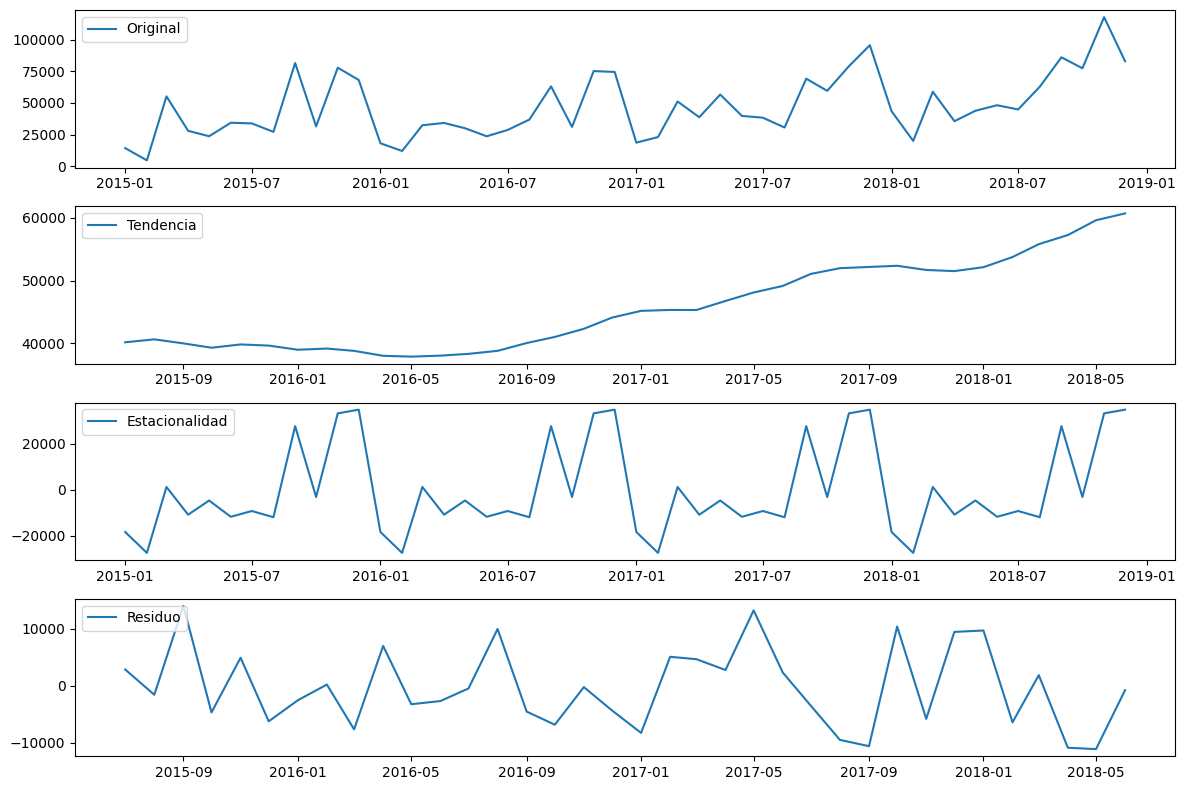

In [45]:
# Descomposición de la serie de tiempo en componentes
result = seasonal_decompose(time_series, model='additive', period=12)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Mostrar los componentes descompuestos
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(time_series, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## los siguientes graficos confirman de manera visual que las alzas ocurren en los mismos meses del año. esto es Estacional.

2. Identificación de Parámetros ARIMA: Utiliza las funciones de autocorrelación (ACF) y
 autocorrelación parcial (PACF) para identificar los posibles valores de los parámetros
 p (orden del término autorregresivo) y q (orden del término de media móvil) en el modelo ARIMA. Además, realiza el test de Dickey-Fuller para determinar si es
 necesario aplicar la diferenciación (valor d) para lograr la estacionaridad.

In [46]:
#dickley-fuller
d = 0
p_value = adfuller(sales['Sales'])[1]
diff_data = sales['Sales']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1


print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 0.00027791039276670623	 Number of differencing needed: 0


## En base al resultado ahora si podemos confirmar que es estacionario

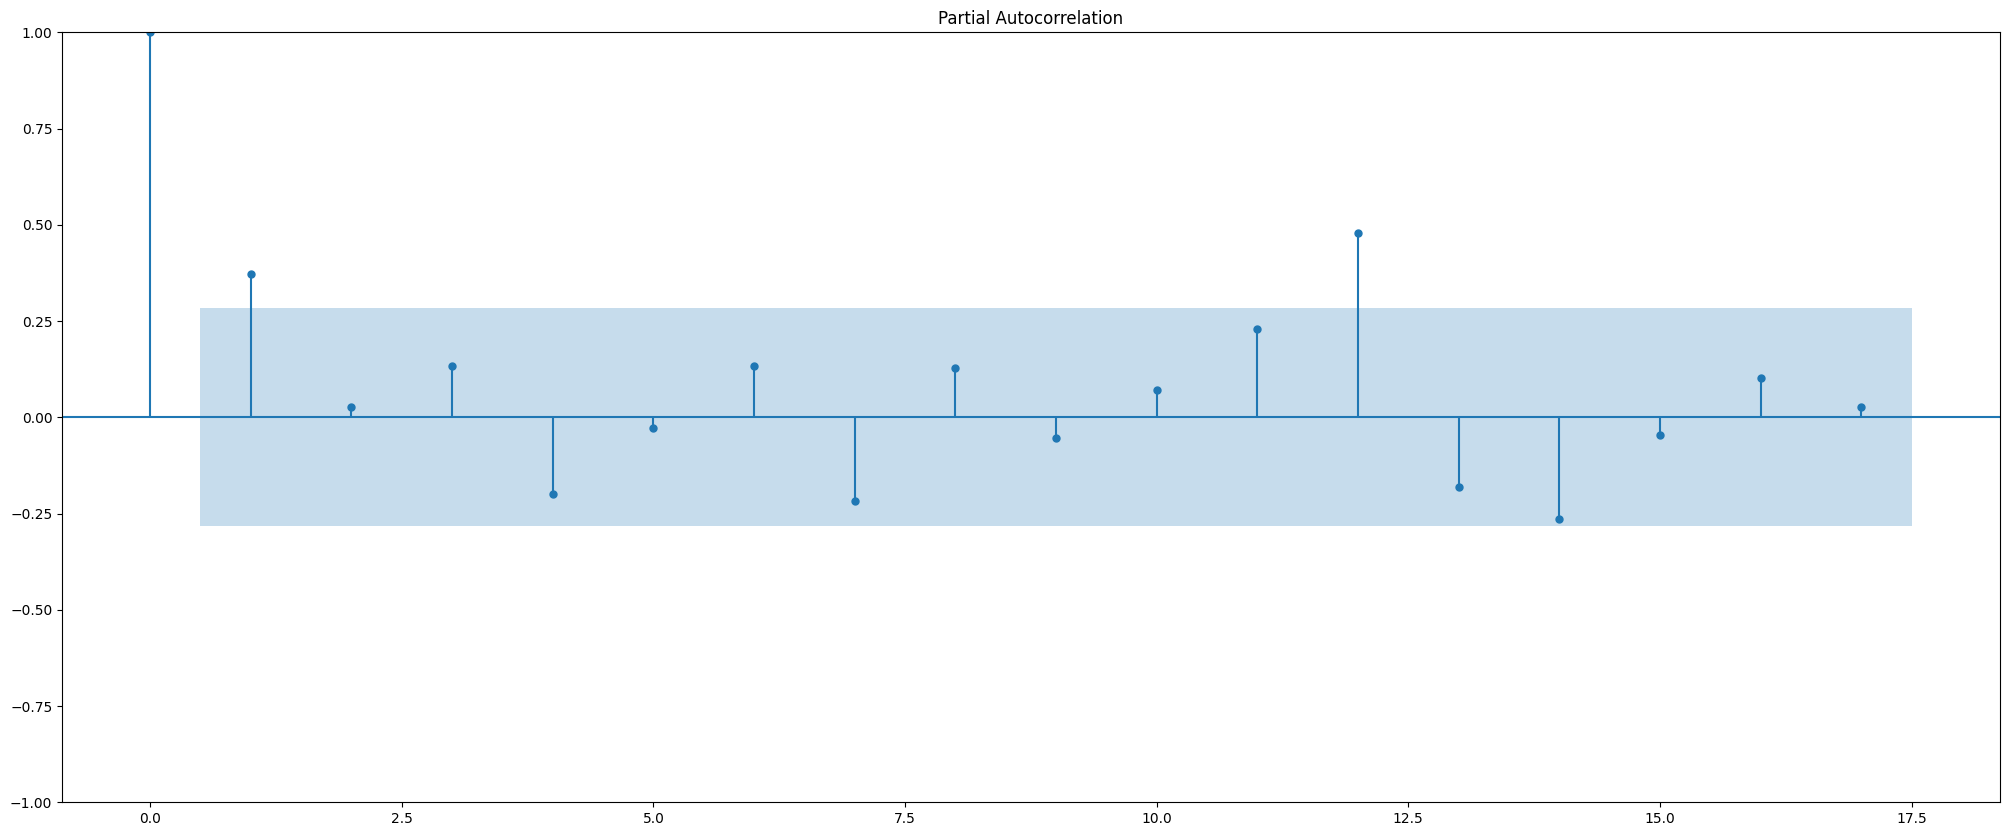

In [47]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(diff_data.dropna(), ax=ax)
plt.show()

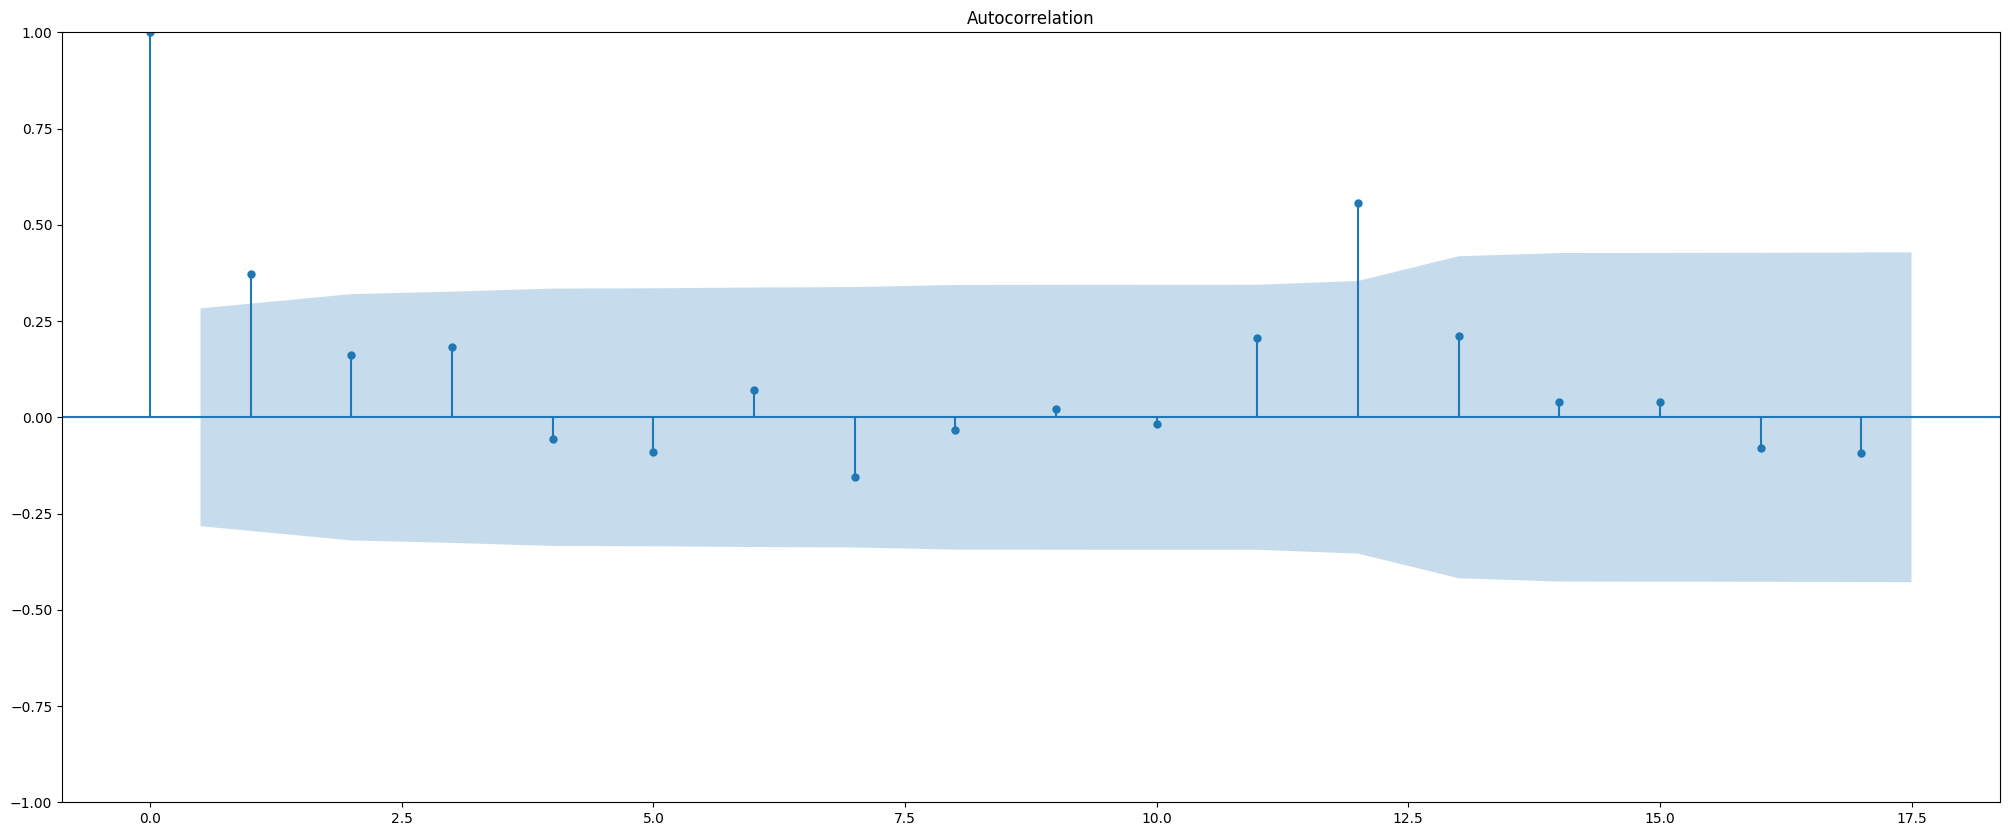

In [48]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(diff_data.dropna(), ax=ax)
plt.show()

In [49]:

# Calcular las autocorrelaciones y autocorrelaciones parciales hasta 20 rezagos
lag_acf = acf(sales['Sales'], nlags=20)
lag_pacf = pacf(sales['Sales'], nlags=20, method='ols')

print("ACF values:")
print(lag_acf)

print("\nPACF values:")
print(lag_pacf)

ACF values:
[ 1.          0.37310501  0.16129133  0.18182543 -0.05678393 -0.09086084
  0.06979553 -0.15412401 -0.03250541  0.02165684 -0.01842194  0.20647836
  0.55653436  0.21163697  0.03906873  0.03845985 -0.07937112 -0.09332761
  0.03632842 -0.16548057 -0.08069303]

PACF values:
[ 1.          0.39155186  0.0959195   0.17502408 -0.19336249 -0.04328502
  0.18540848 -0.25742675  0.14586512 -0.05483843  0.10797921  0.32515584
  0.7911143  -0.00219392 -0.11199577 -0.13044118  0.21561107  0.34532271
  0.10974459 -0.42091842 -0.20903077]


In [50]:
# Crear DataFrame
lags = np.arange(len(lag_acf))
df = pd.DataFrame({
    'Lag': lags,
    'ACF': lag_acf,
    'PACF': lag_pacf,
    'ACF_abs': np.abs(lag_acf),
    'PACF_abs': np.abs(lag_pacf)
})

# Ordenar por valores absolutos de ACF y PACF (ignorando lag=0)
df_acf_sorted = df[df['Lag'] != 0].sort_values(by='ACF_abs', ascending=False)
df_pacf_sorted = df[df['Lag'] != 0].sort_values(by='PACF_abs', ascending=False)

print("📌 Lags más importantes según ACF (para q):")
print(df_acf_sorted.head())

print("\n📌 Lags más importantes según PACF (para p):")
print(df_pacf_sorted.head())

📌 Lags más importantes según ACF (para q):
    Lag       ACF      PACF   ACF_abs  PACF_abs
12   12  0.556534  0.791114  0.556534  0.791114
1     1  0.373105  0.391552  0.373105  0.391552
13   13  0.211637 -0.002194  0.211637  0.002194
11   11  0.206478  0.325156  0.206478  0.325156
3     3  0.181825  0.175024  0.181825  0.175024

📌 Lags más importantes según PACF (para p):
    Lag       ACF      PACF   ACF_abs  PACF_abs
12   12  0.556534  0.791114  0.556534  0.791114
19   19 -0.165481 -0.420918  0.165481  0.420918
1     1  0.373105  0.391552  0.373105  0.391552
17   17 -0.093328  0.345323  0.093328  0.345323
11   11  0.206478  0.325156  0.206478  0.325156


## Los mejores LAGS son el 12

 3. Modelado con ARIMA: Aplica el modelo ARIMA utilizando los parámetros
 identificados en el paso anterior. Ajusta el modelo a los datos históricos de ventas
 mensuales y realiza predicciones para los próximos meses.

In [51]:
model = ARIMA(sales['Sales'], order=(1, 0, 1))

# Ajustar el modelo
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -549.516
Date:                Wed, 05 Nov 2025   AIC                           1107.033
Time:                        20:55:38   BIC                           1114.518
Sample:                             0   HQIC                          1109.861
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.712e+04   6372.221      7.394      0.000    3.46e+04    5.96e+04
ar.L1          0.6655      0.280      2.373      0.018       0.116       1.215
ma.L1         -0.3053      0.353     -0.865      0.3

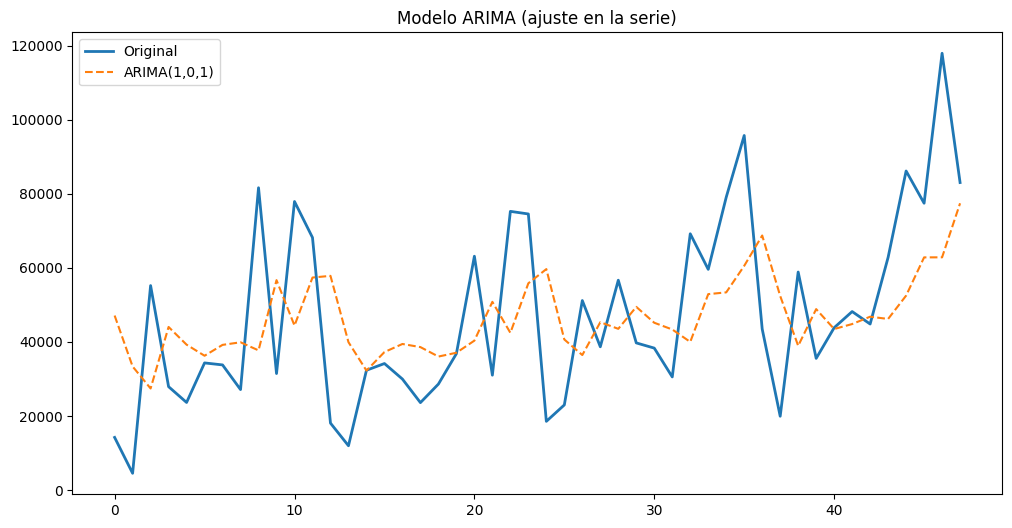

In [52]:
# Predicciones dentro de la muestra
sales['Pred_ARIMA'] = model_fit.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(sales['Sales'], label='Original', linewidth=2)
plt.plot(sales['Pred_ARIMA'], label='ARIMA(1,0,1)', linestyle='--')
plt.title('Modelo ARIMA (ajuste en la serie)')
plt.legend()
plt.show()

## las predicciones muestran picos de ventas mas o menos en los mismos meses que los datos originales

In [54]:
n_steps = 12

# Predicción directa
forecast = model_fit.forecast(steps=n_steps)
print(forecast)

48    69307.252030
49    61884.374751
50    56944.344871
51    53656.685073
52    51468.700950
53    50012.566551
54    49043.488502
55    48398.553345
56    47969.339871
57    47683.692229
58    47493.589681
59    47367.073745
Name: predicted_mean, dtype: float64


## El modelo sigue prediciendo ventas en el mismo intervalo, pero con menores numeros

 4. Evaluación de Predicciones: Divide los datos históricos en un conjunto de
 entrenamiento y uno de prueba. Utiliza el conjunto de entrenamiento para ajustar el
 modelo ARIMA y luego evalúa las predicciones en el conjunto de prueba. Calcula
 métricas de evaluación como el error cuadrático medio (MSE) o el error absoluto
 medio (MAE) para medir el rendimiento del modelo.

In [61]:
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

In [65]:
# ARIMA
model_arima = ARIMA(train['passengers'], order=(11, 0, 2))
model_arima_fit = model_arima.fit()

# auto_arima
model_auto_arima = auto_arima(train_data['passengers'], seasonal=True, m=12)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


NameError: name 'auto_arima' is not defined

# <font color="darkred">Requerimientos</font>

 1. <font color="red">Importar las librerías importantes para el análisis, importar la data y descomponerla
 en sus 3 componentes principales.</font>
 <b>(2 Puntos)</b>

 2. <font color="purple">Buscar los parámetros más indicados para p, d y q de la serie de tiempo, donde
 utilizaremos el test de Dickey-Fuller para encontrar el parámetro d volviendo la serie
 estacionaria, luego utilizar la función de autocorrelación y la función de
 autocorrelación parcial para encontrar <b>p y q.</b></font>
 <b>(4 Puntos)</b>

 3. <font color="darkgreen">Dividir la data en entrenamiento y testeo e instanciar el modelo de <b>ARIMA</b> con los
 parámetros encontrados y la librería <b>statsmodels</b> y también probar <b>auto_arima de la librería pdmarima</b>, finalmente entrenar los parámetros en la data de entrenamiento.</font>
 <b>(2 Puntos)</b>

 4. <font color="blue">Evaluar los modelos en la data de testeo y <b>generar un gráfico del ajuste</b>, como también calcular la métrica.</font>
 <b>(2 Puntos)</b>